#### Packages

In [1]:
# Reference: https://stackoverflow.com/questions/15514593/importerror-no-module-named-when-trying-to-run-python-script/15622021#15622021
import sys
sys.path.append(r'P:\Martin_publication\Grid_Orientation\Flow_Tide')

In [2]:
# Packages
import os
import pathlib
import datetime

import numpy as np
import pandas as pd

import xarray as xr
import rioxarray as rxr
import rasterio as rio

import geopandas as gpd
from shapely.geometry import LineString, Point, MultiPoint

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Set up main directory
main_dir = r"P:\Martin_publication\Grid_Orientation\Flow_Tide"

--------------------------------------------------------------------------------------------

Flow and tidal data are extracted from [Greater Wellington Regional Council](http://graphs.gw.govt.nz/?siteName=Waikanae%20River%20at%20Water%20Treatment%20Plant&dataSource=Flow) from 5th to 7th Jan 2005 and [NIWA Tide Forecaster](https://tides.niwa.co.nz/416?latitude=-40.866&longitude=174.987&datum=MSL&interval=10&startDate=4172005-01-01&numberOfDay) respectively. They are then saved as 'csv' file and saved in 'others' folder.

In [4]:
## FLOW
# http://graphs.gw.govt.nz/?siteName=Waikanae%20River%20at%20Water%20Treatment%20Plant&dataSource=Flow
flowJan2005 = pd.read_csv(fr"{main_dir}\\flow.csv", skiprows=[0], 
                          names=['DateChar', 'Flow', 'Quality'],
                          header=None)

# Get flow data
flowJan2005 = pd.read_csv(fr"{main_dir}\\flow.csv", names=['DateChar', 'Flow', 'Quality'], skiprows=[0], header=None)
flowJan2005 = flowJan2005[['DateChar', 'Flow']]

# Convert time data
flowJan2005['DateTime'] = pd.to_datetime(flowJan2005['DateChar'], format="%m/%d/%Y %H:%M:%S", utc=False)
flowJan2005['DateTime'] = flowJan2005['DateTime'].dt.tz_localize(None)

# Convert timezone
# New Zealand time is 12 hours ahead Universal Time Coordinated --> UTC(0) and NZST(+12)
# So to convert back to UTC, the time needs to be converted back to New Zealand time
# So convert everything to NZST then to UTC
time_change = datetime.timedelta(hours=12)
flowJan2005['DateTime'] = flowJan2005['DateTime'] - time_change

In [5]:
# Get tide data
tideJan2005 = pd.read_csv(fr"{main_dir}\\tide.csv",
                          skiprows=np.arange(0, 9, 1),
                          names=['DateChar', 'Level'],
                          header=None)
# Convert time data
tideJan2005['DateTime'] = pd.to_datetime(tideJan2005['DateChar'], format="%Y-%m-%dT%H:%M:%SZ", utc=False)
tideJan2005['DateTime'] = tideJan2005['DateTime'].dt.tz_localize(None) # Romve timezone

In [6]:
# Convert level data
tideJan2005['Level'] = tideJan2005['Level'] - 0.11

# Align flow and tide data
tide_flowJan2005 = pd.merge(tideJan2005, flowJan2005, how='outer', on='DateTime')[['DateTime', "Flow", "Level"]]
tide_flowJan2005 = tide_flowJan2005.sort_values(by='DateTime').reset_index(drop=True)
tide_flowJan2005['Level'] = tide_flowJan2005['Level'].interpolate(method='cubic')

# Select/Filter time
date_start = pd.to_datetime("2005-01-05 00:00:00")
date_end = pd.to_datetime("2005-01-07 00:00:00")

# Merge tide and flow
tide_flowJan2005 = tide_flowJan2005.loc[(tide_flowJan2005.DateTime >= "2005-01-05 00:00:00")
                                        & (tide_flowJan2005.DateTime <= "2005-01-07 00:00:00")]

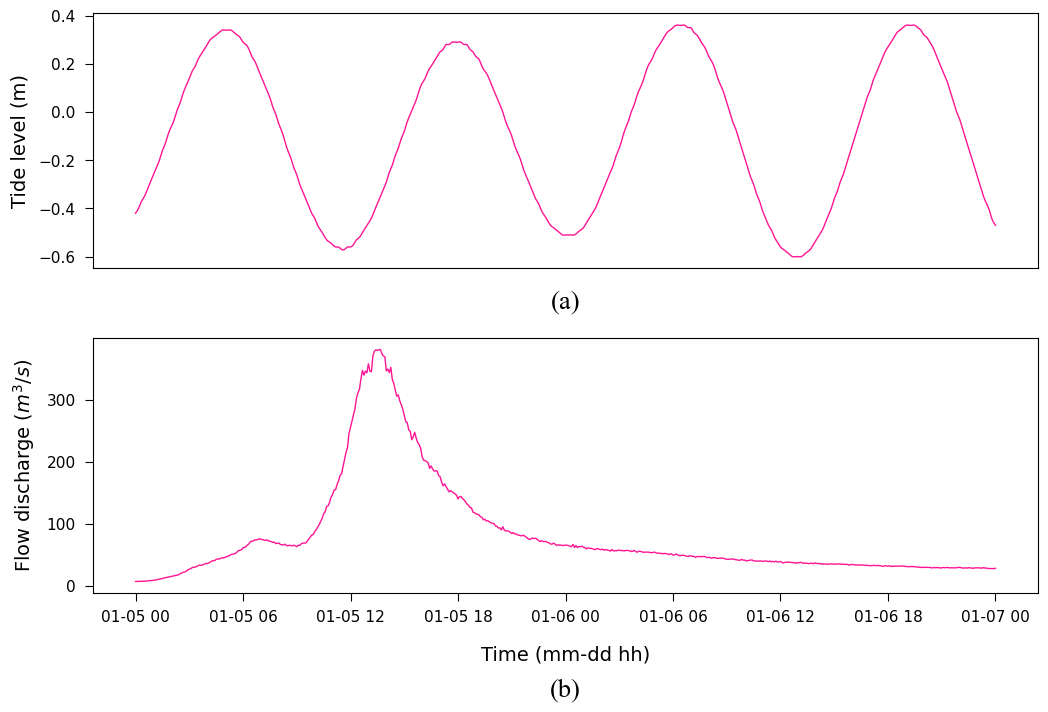

In [7]:
# Ref: https://www.geeksforgeeks.org/how-to-remove-ticks-from-matplotlib-plots/
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.tick_params.html

font_axis_size = 11 
pad_axis_size = 6
length_tick = 6

font_y_label = 14
font_x_label = 14
pad_title_size = 7

# Plot
fig, axes = plt.subplots(2, figsize=(11, 7.2), sharex=True)
fig.tight_layout(pad=4)

# Tide
axes[0].plot(tide_flowJan2005.DateTime, tide_flowJan2005.Level, linewidth=1, color='deeppink')
axes[0].set_ylabel('Tide level (m)', fontsize=font_y_label, labelpad=pad_title_size)
axes[0].tick_params(bottom=False)
axes[0].tick_params(axis='y', length=length_tick, labelsize=font_axis_size, pad=pad_axis_size)

# Caption
font = {'fontname': 'Times New Roman'}
axes[0].text(.5, -.13, '(a)', fontsize=19,
             horizontalalignment='center', verticalalignment='center', linespacing=9.5, **font, transform=axes[0].transAxes)

# Flow
axes[1].plot(tide_flowJan2005.DateTime, tide_flowJan2005.Flow, linewidth=1, color='deeppink')
axes[1].set_xlabel('Time (mm-dd hh)', fontsize=font_x_label, labelpad=15)
axes[1].set_ylabel(r'Flow discharge ($m^{3}/s$)', fontsize=font_y_label, labelpad=pad_title_size)
axes[1].tick_params(axis='y', length=length_tick, labelsize=font_axis_size, pad=pad_axis_size)
axes[1].tick_params(axis='x', length=length_tick, labelsize=font_axis_size, pad=pad_axis_size)

# Caption
font = {'fontname': 'Times New Roman'}
axes[1].text(.5, -.38, '(b)', fontsize=19,
             horizontalalignment='center', verticalalignment='center', linespacing=9.5, **font, transform=axes[1].transAxes)

# Save plots
plt.savefig(fr"{main_dir}\flow_tide.jpg", bbox_inches='tight', dpi=350)

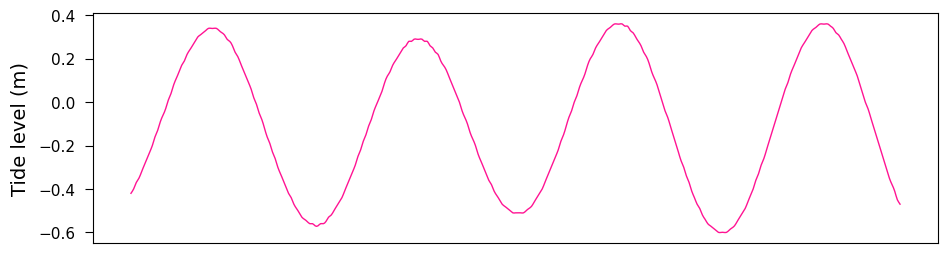

In [37]:
font_axis_size = 11 
pad_axis_size = 6
length_tick = 6

font_y_label = 14
font_x_label = 14
pad_title_size = 7

# Plot
fig, axes = plt.subplots(figsize=(10, 3.7))
fig.tight_layout(pad=4)

# Tide
axes.plot(tide_flowJan2005.DateTime, tide_flowJan2005.Level, linewidth=1, color='deeppink')
# axes.set_xlabel('Time (mm-dd hh)', fontsize=font_x_label, labelpad=15)
axes.set_ylabel('Tide level (m)', fontsize=font_y_label, labelpad=pad_title_size)
axes.tick_params(bottom=False, labelbottom = False)
axes.tick_params(axis='y', length=length_tick, labelsize=font_axis_size, pad=pad_axis_size)
# axes.tick_params(axis='x', length=length_tick, labelsize=font_axis_size, pad=pad_axis_size)

# Save plots
plt.savefig(fr"{main_dir}\tide.jpg", bbox_inches='tight', dpi=350)

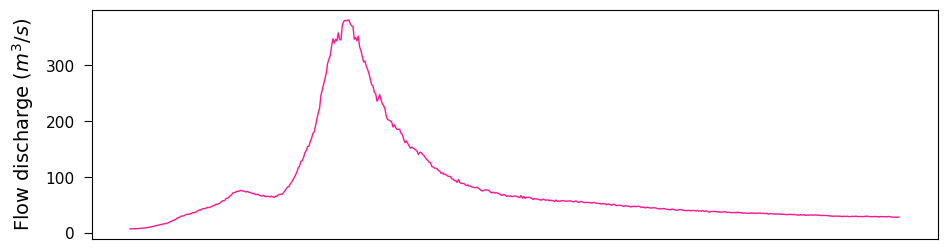

In [38]:
font_axis_size = 11 
pad_axis_size = 6
length_tick = 6

font_y_label = 14
font_x_label = 14
pad_title_size = 7

# Plot
fig, axes = plt.subplots(figsize=(10, 3.7))
fig.tight_layout(pad=4)

# Tide
axes.plot(tide_flowJan2005.DateTime, tide_flowJan2005.Flow, linewidth=1, color='deeppink')
# axes.set_xlabel('Time (mm-dd hh)', fontsize=font_x_label, labelpad=15)
axes.set_ylabel(r'Flow discharge ($m^{3}/s$)', fontsize=font_y_label, labelpad=pad_title_size)
axes.tick_params(bottom=False, labelbottom=False)
axes.locator_params(nbins=5, axis='y')
axes.tick_params(axis='y', length=length_tick, labelsize=font_axis_size, pad=pad_axis_size)
# axes.tick_params(axis='x', length=length_tick, labelsize=font_axis_size, pad=pad_axis_size)


# Save plots
plt.savefig(fr"{main_dir}\flow.jpg", bbox_inches='tight', dpi=350)